In [ ]:
!wget "https://archive.ics.uci.edu/ml/machine-learning-databases/00462/drugsCom_raw.zip"
!unzip drugsCom_raw.zip

--2022-07-18 04:55:36--  https://archive.ics.uci.edu/ml/machine-learning-databases/00462/drugsCom_raw.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 42989872 (41M) [application/x-httpd-php]
Saving to: ‘drugsCom_raw.zip’

drugsCom_raw.zip    100%[===================>]  41.00M  28.9MB/s    in 1.4s    

2022-07-18 04:55:38 (28.9 MB/s) - ‘drugsCom_raw.zip’ saved [42989872/42989872]

Archive:  drugsCom_raw.zip
  inflating: drugsComTest_raw.tsv    
  inflating: drugsComTrain_raw.tsv   


In [ ]:
import numpy as np
import pandas as pd
import os
import spacy
import en_core_web_sm
from spacy.lang.en import English
from spacy.lang.en.stop_words import STOP_WORDS
import string
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.feature_extraction import DictVectorizer
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer,HashingVectorizer
from sklearn.base import TransformerMixin
from sklearn.pipeline import Pipeline
!pip install vaderSentiment
import vaderSentiment
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# preprocessing the data file
#  read the data
df1 = pd.read_csv("./drugsComTrain_raw.tsv",sep='\t')
df2 = pd.read_csv("./drugsComTest_raw.tsv",sep='\t')
# combine two file
df = pd.concat([df1, df2])

# rename the cols
df.columns = ['ID','drug name','condition','review','rating','date','useful count']

In [ ]:
df

,ID,drug name,condition,review,rating,date,useful count
0,206461,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9.0,"May 20, 2012",27
1,95260,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8.0,"April 27, 2010",192
2,92703,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5.0,"December 14, 2009",17
3,138000,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8.0,"November 3, 2015",10
4,35696,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9.0,"November 27, 2016",37
...,...,...,...,...,...,...,...
53761,159999,Tamoxifen,"Breast Cancer, Prevention","""I have taken Tamoxifen for 5 years. Side effe...",10.0,"September 13, 2014",43
53762,140714,Escitalopram,Anxiety,"""I&#039;ve been taking Lexapro (escitaploprgra...",9.0,"October 8, 2016",11
53763,130945,Levonorgestrel,Birth Control,"""I&#039;m married, 34 years old and I have no ...",8.0,"November 15, 2010",7
53764,47656,Tapentadol,Pain,"""I was prescribed Nucynta for severe neck/shou...",1.0,"November 28, 2011",20


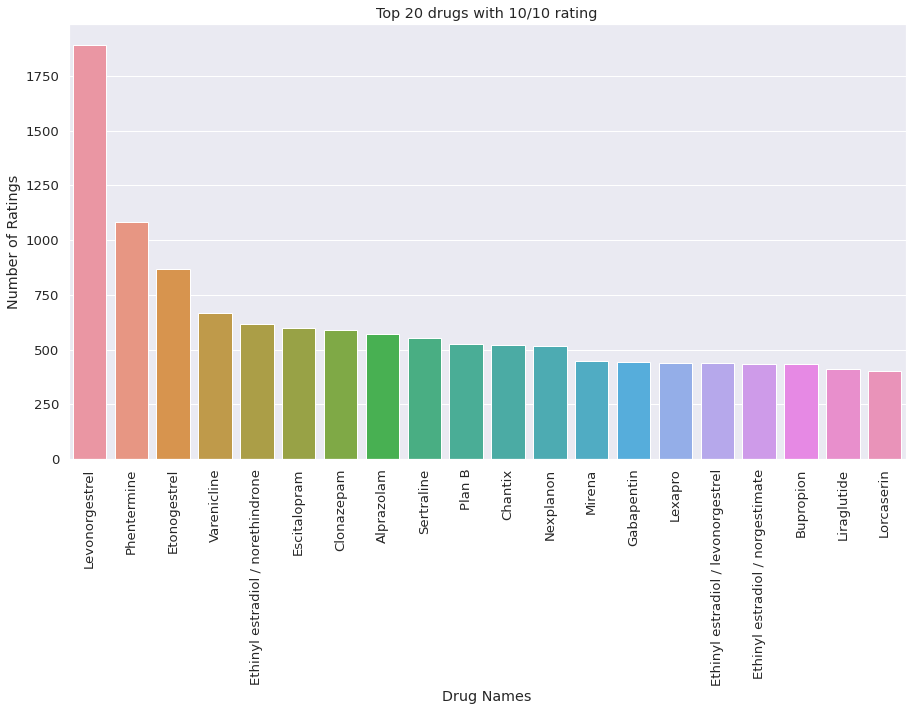

In [ ]:
import seaborn as sns
#!pip install matplotlib
import matplotlib.pyplot as plt

# Setting the Parameter
sns.set(font_scale = 1.2, style = 'darkgrid')
plt.rcParams['figure.figsize'] = [15, 8]

rating = dict(df.loc[df.rating == 10, "drug name"].value_counts())
drugname = list(rating.keys())
drug_rating = list(rating.values())

sns_rating = sns.barplot(x = drugname[0:20], y = drug_rating[0:20])

sns_rating.set_title('Top 20 drugs with 10/10 rating')
sns_rating.set_ylabel("Number of Ratings")
sns_rating.set_xlabel("Drug Names")
plt.setp(sns_rating.get_xticklabels(), rotation=90);

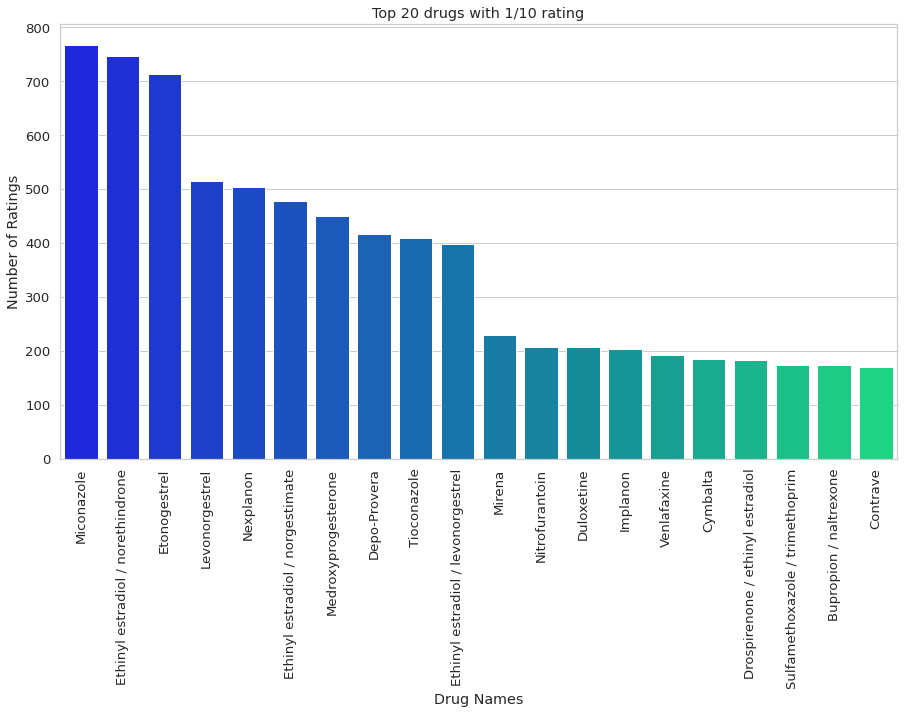

In [ ]:
# Setting the Parameter
sns.set(font_scale = 1.2, style = 'whitegrid')
plt.rcParams['figure.figsize'] = [15, 8]

rating = dict(df.loc[df.rating == 1, "drug name"].value_counts())
drugname = list(rating.keys())
drug_rating = list(rating.values())

sns_rating = sns.barplot(x = drugname[0:20], y = drug_rating[0:20], palette = 'winter')

sns_rating.set_title('Top 20 drugs with 1/10 rating')
sns_rating.set_ylabel("Number of Ratings")
sns_rating.set_xlabel("Drug Names")
plt.setp(sns_rating.get_xticklabels(), rotation=90);

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 0, 'Rating')

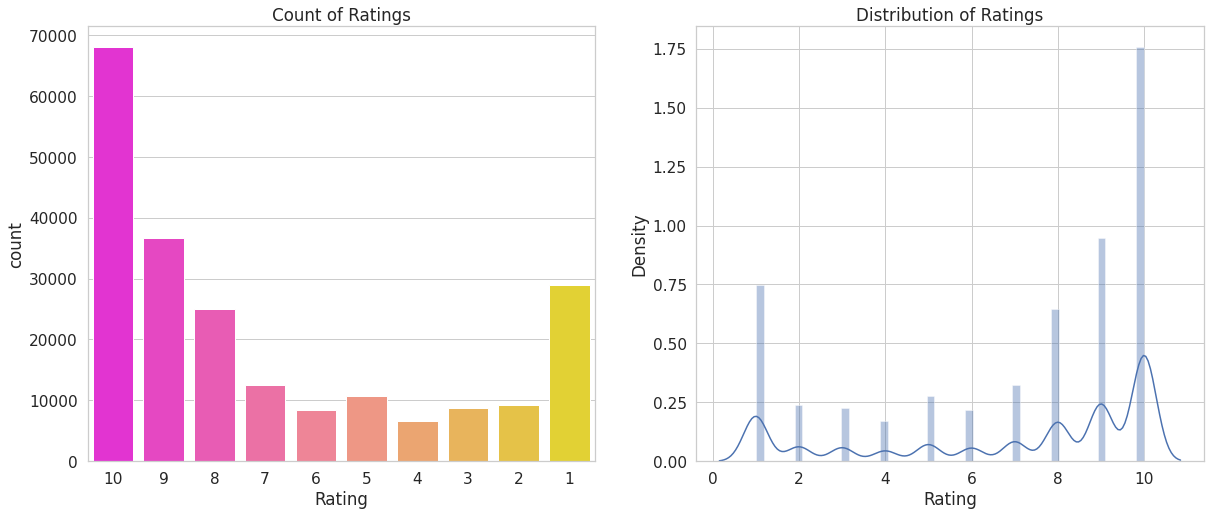

In [ ]:
# A countplot of the ratings so we can see the distribution of the ratings
plt.rcParams['figure.figsize'] = [20,8]
sns.set(font_scale = 1.4, style = 'whitegrid')
fig, ax = plt.subplots(1, 2)

sns_1 = sns.countplot(df['rating'], palette = 'spring', order = list(range(10, 0, -1)), ax = ax[0])
sns_2 = sns.distplot(df['rating'], ax = ax[1])
sns_1.set_title('Count of Ratings')
sns_1.set_xlabel("Rating")

sns_2.set_title('Distribution of Ratings')
sns_2.set_xlabel("Rating")

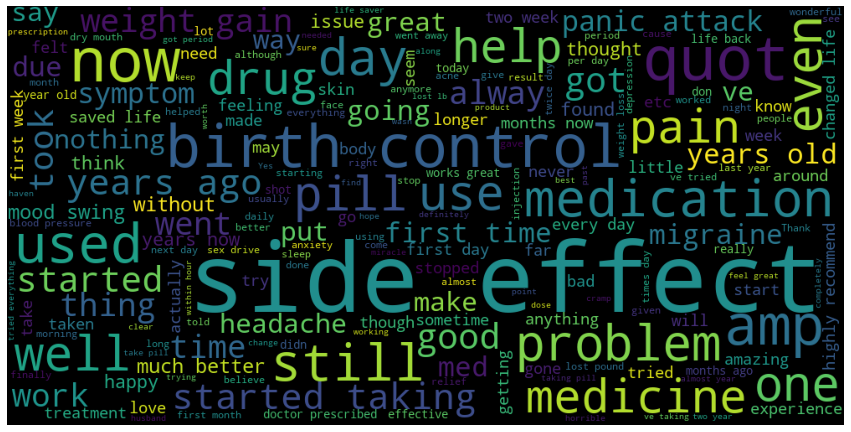

In [ ]:
#!pip install wordcloud
from wordcloud import WordCloud# Word cloud of the reviews with rating equal to 10
df_rate_ten = df.loc[df.rating == 10, 'review']
k = (' '.join(df_rate_ten))

wordcloud = WordCloud(width = 1000, height = 500).generate(k)
plt.figure(figsize=(15, 10))
plt.imshow(wordcloud)
plt.axis('off');

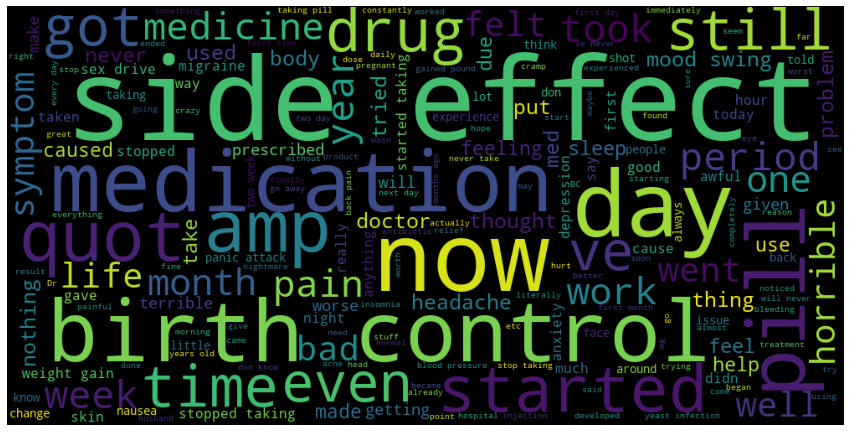

In [ ]:
from wordcloud import WordCloud# Word cloud of the reviews with rating equal to 1
df_rate_ten = df.loc[df.rating == 1, 'review']
k = (' '.join(df_rate_ten))

wordcloud = WordCloud(width = 1000, height = 500).generate(k)
plt.figure(figsize=(15, 10))
plt.imshow(wordcloud)
plt.axis('off');


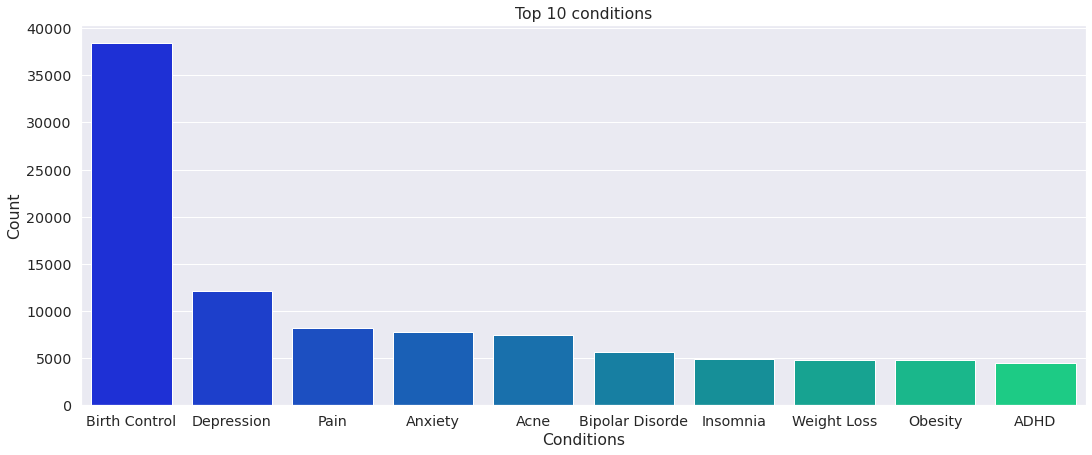

In [ ]:
# This barplot show the top 10 conditions the people are suffering.
cond = dict(df['condition'].value_counts())
top_condition = list(cond.keys())[0:10]
values = list(cond.values())[0:10]
sns.set(style = 'darkgrid', font_scale = 1.3)
plt.rcParams['figure.figsize'] = [18, 7]

sns_ = sns.barplot(x = top_condition, y = values, palette = 'winter')
sns_.set_title("Top 10 conditions")
sns_.set_xlabel("Conditions")
sns_.set_ylabel("Count");

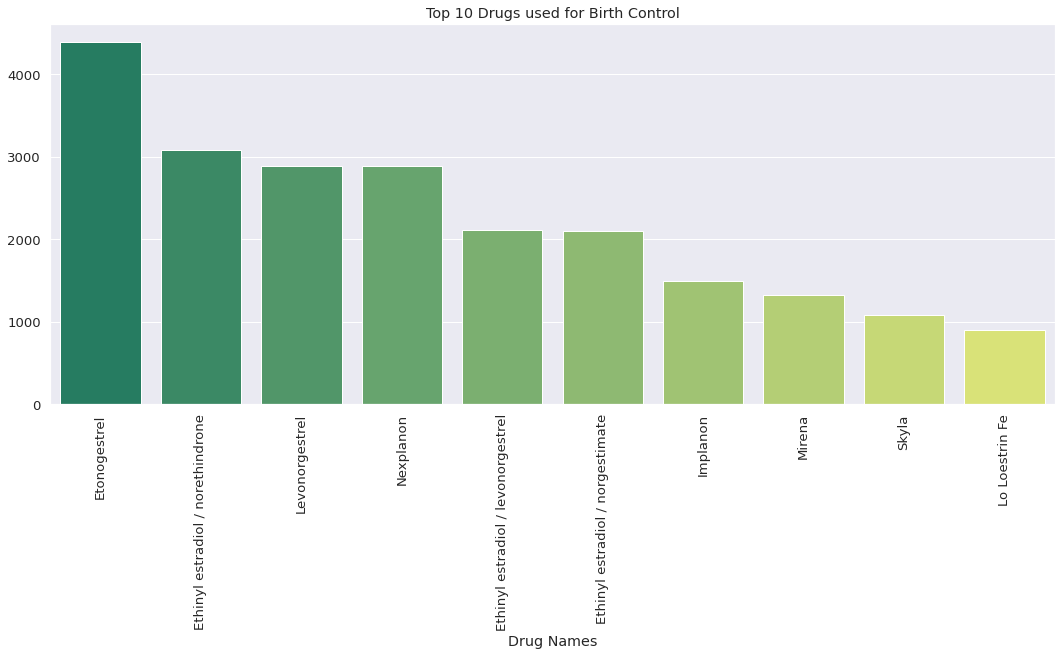

In [ ]:
# Top 10 drugs which are used for the top condition, that is Birth Control
df = df[df['condition'] == 'Birth Control']['drug name'].value_counts()[0: 10]
sns.set(font_scale = 1.2, style = 'darkgrid')

sns_ = sns.barplot(x = df.index, y = df.values, palette = 'summer')
sns_.set_xlabel('Drug Names')
sns_.set_title("Top 10 Drugs used for Birth Control")
plt.setp(sns_.get_xticklabels(), rotation = 90);

In [ ]:
# preprocessing the data file
#  read the data
df1 = pd.read_csv("./drugsComTrain_raw.tsv",sep='\t')
df2 = pd.read_csv("./drugsComTest_raw.tsv",sep='\t')
# combine two file
df = pd.concat([df1, df2])

# rename the cols
df.columns = ['ID','drug name','condition','review','rating','date','useful count']
df

,ID,drug name,condition,review,rating,date,useful count
0,206461,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9.0,"May 20, 2012",27
1,95260,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8.0,"April 27, 2010",192
2,92703,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5.0,"December 14, 2009",17
3,138000,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8.0,"November 3, 2015",10
4,35696,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9.0,"November 27, 2016",37
...,...,...,...,...,...,...,...
53761,159999,Tamoxifen,"Breast Cancer, Prevention","""I have taken Tamoxifen for 5 years. Side effe...",10.0,"September 13, 2014",43
53762,140714,Escitalopram,Anxiety,"""I&#039;ve been taking Lexapro (escitaploprgra...",9.0,"October 8, 2016",11
53763,130945,Levonorgestrel,Birth Control,"""I&#039;m married, 34 years old and I have no ...",8.0,"November 15, 2010",7
53764,47656,Tapentadol,Pain,"""I was prescribed Nucynta for severe neck/shou...",1.0,"November 28, 2011",20


In [ ]:
df

,ID,drug name,condition,review,rating,date,useful count
0,206461,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9.0,"May 20, 2012",27
1,95260,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8.0,"April 27, 2010",192
2,92703,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5.0,"December 14, 2009",17
3,138000,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8.0,"November 3, 2015",10
4,35696,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9.0,"November 27, 2016",37
...,...,...,...,...,...,...,...
53761,159999,Tamoxifen,"Breast Cancer, Prevention","""I have taken Tamoxifen for 5 years. Side effe...",10.0,"September 13, 2014",43
53762,140714,Escitalopram,Anxiety,"""I&#039;ve been taking Lexapro (escitaploprgra...",9.0,"October 8, 2016",11
53763,130945,Levonorgestrel,Birth Control,"""I&#039;m married, 34 years old and I have no ...",8.0,"November 15, 2010",7
53764,47656,Tapentadol,Pain,"""I was prescribed Nucynta for severe neck/shou...",1.0,"November 28, 2011",20


In [ ]:
df_condition = df2.groupby(['condition'])['drugName'].nunique().sort_values(ascending=False)
df_condition = pd.DataFrame(df_condition).reset_index()
df_condition.columns = ['condition','drug name']
df_condition.tail(20)

,condition,drug name
688,Progesterone Insufficiency,1
689,"Anemia, Chemotherapy Induced",1
690,Keratitis,1
691,Coronary Artery Disease,1
692,Costochondritis,1
693,Joint Infection,1
694,Anaplastic Astrocytoma,1
695,Pudendal Neuralgia,1
696,Reversal of Nondepolarizing Muscle Relaxants,1
697,Pulmonary Edema,1


In [ ]:
df_condition_1 = df_condition[df_condition['drug name'] == 1].reset_index()

all_list = set(df.index)

# deleting them
condition_list = []
for i,j in enumerate(df['condition']):
    for c in list(df_condition_1['condition']):
        if j == c:
            condition_list.append(i)
            
new_idx = all_list.difference(set(condition_list))
df = df.iloc[list(new_idx)].reset_index()
del df['index']

In [ ]:
df.shape


(160229, 7)

In [ ]:
# removing the conditions with <span> in it.

all_list = set(df.index)
span_list = []
for i,j in enumerate(df['condition']):
    if "</span>" in str(j):
        span_list.append(i)
new_idx = all_list.difference(set(span_list))
df = df.iloc[list(new_idx)].reset_index()
del df['index']

In [ ]:
import re
from bs4 import BeautifulSoup
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.porter import PorterStemmer

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
# removing some stopwords from the list of stopwords as they are important for drug recommendation

stops = set(stopwords.words('english'))

not_stop = ["aren't","couldn't","didn't","doesn't","don't","hadn't","hasn't","haven't","isn't","mightn't",
            "mustn't","needn't","no","nor","not","shan't","shouldn't","wasn't","weren't","wouldn't"]
for i in not_stop:
    stops.remove(i)

In [ ]:
stemmer = SnowballStemmer('english')

def review_to_words(raw_review):
    # 1. Delete HTML 
    review_text = BeautifulSoup(raw_review, 'html.parser').get_text()
    # 2. Make a space
    letters_only = re.sub('[^a-zA-Z]', ' ', review_text)
    # 3. lower letters
    words = letters_only.lower().split()
    # 5. Stopwords 
    meaningful_words = [w for w in words if not w in stops]
    # 6. Stemming
    stemming_words = [stemmer.stem(w) for w in meaningful_words]
    # 7. space join words
    return( ' '.join(stemming_words))

# create a list of stopwords
nlp = spacy.load('en_core_web_sm')
stop_words = spacy.lang.en.stop_words.STOP_WORDS
parser = English()
punctuations = string.punctuation
# Creating our tokenizer function
def spacy_tokenizer(sentence):
    # Creating our token object, which is used to create documents with linguistic annotations.
    mytokens = parser(sentence)

    # Lemmatizing each token and converting each token into lowercase
    mytokens = [ word.lemma_.lower().strip() if word.lemma_ != "-PRON-" else word.lower_ for word in mytokens ]

    # Removing stop words
    mytokens = [ word for word in mytokens if word not in stop_words and word not in punctuations ]

    # return preprocessed list of tokens
    return mytokens

In [ ]:
%time df['review_clean'] = df['review'].apply(review_to_words)
df.head()

CPU times: user 1min 58s, sys: 655 ms, total: 1min 59s
Wall time: 2min


,ID,drug name,condition,review,rating,date,useful count,review_clean
0,206461,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9.0,"May 20, 2012",27,no side effect take combin bystol mg fish oil
1,95260,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8.0,"April 27, 2010",192,son halfway fourth week intuniv becam concern ...
2,92703,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5.0,"December 14, 2009",17,use take anoth oral contracept pill cycl happi...
3,138000,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8.0,"November 3, 2015",10,first time use form birth control glad went pa...
4,35696,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9.0,"November 27, 2016",37,suboxon complet turn life around feel healthie...


In [ ]:
bow_vector = CountVectorizer(tokenizer = spacy_tokenizer, ngram_range=(1,2))
#  tf-idf vector
tfidf_vector = TfidfVectorizer(tokenizer = spacy_tokenizer)

In [23]:
# part 1---vader sentiment analyzer for c_review
analyzer = SentimentIntensityAnalyzer()
# create new col vaderReviewScore based on C-review
df['vaderReviewScore'] = df['review_clean'].apply(lambda x: analyzer.polarity_scores(x)['compound'])

# define the positive, neutral and negative
positive_num = len(df[df['vaderReviewScore'] >=0.05])
neutral_num = len(df[(df['vaderReviewScore'] >-0.05) & (df['vaderReviewScore']<0.05)])
negative_num = len(df[df['vaderReviewScore']<=-0.05])

# create new col vaderSentiment based on vaderReviewScore
df['vaderSentiment'] = df['vaderReviewScore'].map(lambda x:int(2) if x>=0.05 else int(1) if x<=-0.05 else int(0) )
df['vaderSentiment'].value_counts() # 2-pos: 99519; 1-neg: 104434; 0-neu: 11110

# label pos/neg/neu based on vaderSentiment result
df.loc[df['vaderReviewScore'] >=0.05,"vaderSentimentLabel"] ="positive"
df.loc[(df['vaderReviewScore'] >-0.05) & (df['vaderReviewScore']<0.05),"vaderSentimentLabel"]= "neutral"
df.loc[df['vaderReviewScore']<=-0.05,"vaderSentimentLabel"] = "negative"

In [24]:
df['vaderReviewScore'].max()


0.9935

In [25]:
df['vaderReviewScore'].min()


-0.9973

In [26]:
#Normalizing "vaderReviewScore"
criteria = [df['vaderReviewScore'].between(-0.997, -0.799), df['vaderReviewScore'].between(-0.798, -0.601), df['vaderReviewScore'].between(-0.600, 0.403), df['vaderReviewScore'].between(-0.402, -0.205), df['vaderReviewScore'].between(-0.204, -0.007), df['vaderReviewScore'].between(-0.006,0.191), df['vaderReviewScore'].between(0.192, 0.389), df['vaderReviewScore'].between(0.390, 0.587), df['vaderReviewScore'].between(0.588, 0.785), df['vaderReviewScore'].between(0.786, 1)]
values = [1, 2, 3,4,5,6,7,8,9,10]

df['normalVaderScore'] = np.select(criteria, values, 0)
df

,ID,drug name,condition,review,rating,date,useful count,review_clean,vaderReviewScore,vaderSentiment,vaderSentimentLabel,normalVaderScore
0,206461,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9.0,"May 20, 2012",27,no side effect take combin bystol mg fish oil,-0.2960,1,negative,3
1,95260,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8.0,"April 27, 2010",192,son halfway fourth week intuniv becam concern ...,0.6929,2,positive,9
2,92703,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5.0,"December 14, 2009",17,use take anoth oral contracept pill cycl happi...,0.2732,2,positive,3
3,138000,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8.0,"November 3, 2015",10,first time use form birth control glad went pa...,0.4199,2,positive,8
4,35696,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9.0,"November 27, 2016",37,suboxon complet turn life around feel healthie...,0.8934,2,positive,10
...,...,...,...,...,...,...,...,...,...,...,...,...
159343,191035,Campral,Alcohol Dependence,"""I wrote my first report in Mid-October of 201...",10.0,"May 31, 2015",125,wrote first report mid octob not alcohol sinc ...,0.9362,2,positive,10
159344,127085,Metoclopramide,Nausea/Vomiting,"""I was given this in IV before surgey. I immed...",1.0,"November 1, 2011",34,given iv surgey immedi becam anxious could not...,-0.2732,1,negative,3
159345,187382,Orencia,Rheumatoid Arthritis,"""Limited improvement after 4 months, developed...",2.0,"March 15, 2014",35,limit improv month develop bad rash md refus c...,-0.7351,1,negative,2
159346,47128,Thyroid desiccated,Underactive Thyroid,"""I&#039;ve been on thyroid medication 49 years...",10.0,"September 19, 2015",79,thyroid medic year spent first synthroid vario...,0.7655,2,positive,9


In [27]:
#Final Normalized Score combining Rating and normalVaderScore
df['meanNormalizedScore'] = (df['rating'] + df['normalVaderScore'])/2
df.head()

,ID,drug name,condition,review,rating,date,useful count,review_clean,vaderReviewScore,vaderSentiment,vaderSentimentLabel,normalVaderScore,meanNormalizedScore
0,206461,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9.0,"May 20, 2012",27,no side effect take combin bystol mg fish oil,-0.2960,1,negative,3,6.0
1,95260,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8.0,"April 27, 2010",192,son halfway fourth week intuniv becam concern ...,0.6929,2,positive,9,8.5
2,92703,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5.0,"December 14, 2009",17,use take anoth oral contracept pill cycl happi...,0.2732,2,positive,3,4.0
3,138000,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8.0,"November 3, 2015",10,first time use form birth control glad went pa...,0.4199,2,positive,8,8.0
4,35696,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9.0,"November 27, 2016",37,suboxon complet turn life around feel healthie...,0.8934,2,positive,10,9.5


In [28]:
#Sorting Data based on Condition and then by drug
grouped = df.groupby(['condition','drug name']).agg({'meanNormalizedScore' : ['mean']})
grouped.to_csv('Grouped_Drug_Recommendation_Normalized')
grouped.head(10)

meanNormalizedScore
                                                         mean
condition drug name                                          
ADHD      Adderall                                   6.990625
          Adderall XR                                7.172897
          Adzenys XR-ODT                             6.805556
          Amantadine                                 5.666667
          Amphetamine                                6.522727
          Amphetamine / dextroamphetamine            6.941926
          Aptensio XR                                5.833333
          Armodafinil                                6.937500
          Atomoxetine                                5.182266
          Bupropion                                  6.879310